In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import toml
import h5py
import joblib
import pandas as pd
import seaborn as sns
import re
import warnings
import json

from glob import glob
from tqdm.auto import tqdm
from markovids import vid, pcl
from qd_analysis.fig import setup_plotting_env

## Gather data and predicted keypoints

In [3]:
config = toml.load("../preprocessing/config.toml")
save_file = os.path.join(config["dirs"]["data"], "dataframes/sleap_metrics_qd_training.parquet")

fig_dir = config["dirs"]["figs"]
os.makedirs(fig_dir, exist_ok=True)

In [4]:
data_dir = os.path.join(config["dirs"]["data"], "dataframes/")
data_files = sorted(glob(os.path.join(data_dir, "manually_labeled_data_*.parquet")))

In [5]:
dfs = []
for _file in tqdm(data_files):
    _df = pd.read_parquet(_file)
    _df["filename"] = _file
    dfs.append(_df)

  0%|          | 0/3 [00:00<?, ?it/s]

# Analyze results

In [6]:
result_df = pd.concat(dfs, ignore_index=True)

In [7]:
def get_l2_norm(df, x1="kpoint_x", x2="gt_x", y1="kpoint_y", y2="gt_y"):
    return np.linalg.norm([df[x1] - df[x2], df[y1] - df[y2]])

In [8]:
tqdm.pandas()

In [9]:
aliases = {"(0.0, 1.0)": "reflect",
           "(1.0, 0.0)": "fluo",
           "None": "reflect+fluo"}

In [10]:
result_df["model_input"] = result_df["model_weight"].map(aliases)

In [11]:
# fluo_threshold = 200
dist_cols = ["kpoint_com_gauss_gt_l2","kpoint_gt_l2"]
dset_type = "test"

In [12]:
palette = dict(list(zip(["reflect","fluo","reflect+fluo"], sns.color_palette("tab10"))))

# first plot different modalities, what should we use?

In [13]:
plt_df = result_df.query("filename.str.contains('modalities') and dset_type == @dset_type").copy()
# plt_df["high_fluo"] = plt_df["kpoint_amp_gauss"] > fluo_threshold

In [14]:
ave_df = plt_df.groupby(["model_input","model_dir"])[dist_cols].mean().reset_index()

In [15]:
setup_plotting_env()

/tmp/ipykernel_243880/221097915.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


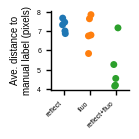

In [16]:
fig, ax = plt.subplots(1, figsize=(1.4, 1.4))
sns.stripplot(
    data=ave_df,
    order=list(palette.keys()),
    hue="model_input",
    palette=palette,
    x="model_input",
    y="kpoint_gt_l2",
)
ax.set_xlabel("")
ax.set_ylabel("Ave. distance to\nmanual label (pixels)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
sns.despine()
fig.tight_layout()
fig.savefig(os.path.join(fig_dir, "manual_label_performance_modalities.pdf"), bbox_inches="tight", dpi=600)

In [17]:
plt_df2 = (
    plt_df
    .groupby(["model_input", "model_dir"])[dist_cols]
    .mean()
    .melt(ignore_index=False)
    .reset_index()
)

/tmp/ipykernel_243880/3154690374.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.axes.ravel()[-1].set_xticklabels(["w/o fluo.","w/ fluo."], rotation=45, ha='right')


[Text(0, 0, 'w/o fluo.'), Text(1, 0, 'w/ fluo.')]

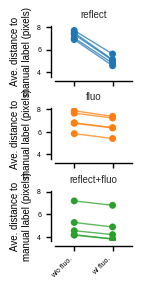

In [18]:
# fig, ax = plt.subplots(1, figsize=(1.25, 2.))
g = sns.catplot(
    sharey=True,
    kind="strip",
    data=plt_df2,
    row="model_input",
    row_order=list(palette.keys()),
    y="value",
    hue="model_input",
    palette=palette,
    x="variable",
    order=["kpoint_gt_l2","kpoint_com_gauss_gt_l2"],
    height=.95,
    jitter=False,
    legend=False,
    aspect=1.7,
)

def test(x, y, use_id, hue, color, data):
    ax = plt.gca()
    xticks = ax.get_xticks()
    ids = data[use_id].unique()
    for _id in ids:
        pts = data.loc[data[use_id] == _id][y].values[::-1]
        plt.plot(xticks, pts, lw=1, alpha=.75, color=palette[data[hue].iat[0]])

g.map_dataframe(test, "variable", "value", "model_dir", "model_input")
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.set(ylabel="Ave. distance to\nmanual label (pixels)", xlabel="", xlim=(-.5, 1.5))
sns.despine(offset=3, trim=False)
g.axes.ravel()[-1].set_xticklabels(["w/o fluo.","w/ fluo."], rotation=45, ha='right')
# g.fig.savefig(os.path.join(fig_dir, "manual_label_performance_refinement_per_model.pdf"), bbox_inches="tight", dpi=600)

In [19]:
plt_df["kpoint_com_gauss_diff"] = plt_df["kpoint_com_gauss_gt_l2"] - plt_df["kpoint_gt_l2"]

In [20]:
# get best model for diffs

In [21]:
best_models = plt_df.groupby(["model_input","model_dir"])["kpoint_gt_l2"].mean().groupby("model_input").idxmin()

In [22]:
best_models = best_models.apply(lambda x: x[1]).tolist()

In [23]:
plt_df2 = plt_df

In [24]:
diffs = plt_df2.groupby(["model_input","dset_index"])["kpoint_com_gauss_diff"].mean().reset_index()

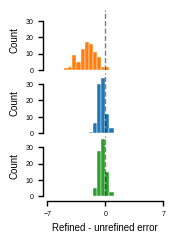

In [25]:
g = sns.displot(
    data=diffs,
    fill=True,
    x="kpoint_com_gauss_diff",
    row="model_input",
    row_order=list(palette.keys()),
    hue="model_input",
    kind="hist",
    height=.8,
    alpha=1,
    aspect=2.15,
    legend=False,
    bins=np.arange(-7,7,.5),
    facet_kws={"sharex":True,"sharey":True},
)
g.set(xlim=(-6,6), xticks=(-7,0,7), xlabel="Refined - unrefined error", title="")
g.refline(x=0, color="k", alpha=.5)
plt.subplots_adjust(hspace=.05)
sns.despine(trim=True, offset=3)
for _ax in g.fig.axes[:-1]:
    _ax.tick_params(axis='x', length=0)
    _ax.spines['bottom'].set_visible(False)
g.fig.savefig(os.path.join(fig_dir, "manual_label_performance_refinement_per_frame.pdf"), bbox_inches="tight", dpi=600)
# g.set_titles(col_template="", row_template="")

# Now that we've shown refinement let's show performance across subsamples

In [26]:
plt_df = result_df.query("filename.str.contains('subsample') and dset_type == @dset_type").copy()
plt_df["high_fluo"] = plt_df["kpoint_amp_gauss"] > 0

In [27]:
plt_df2 = plt_df.query("high_fluo").groupby(["nframes train","model_dir","model_weight"])[dist_cols].mean().melt(ignore_index=False).reset_index()

In [28]:
from scipy.optimize import curve_fit, least_squares

In [29]:
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c
# def log_decay(x, a, x0, c):
    # return a * np.log(x + x0) + c
def power_law_decay(x, a, b, c):
    return a / ((x + 1) ** b) + c

In [30]:
def residuals(params, x, y):
    a, b, c = params
    return power_law_decay(x, a, b, c) - y

In [31]:
# resample data 1,000 times, refit, etc.

In [32]:
domain = (50, 700)
bounds = ([1e-6, 0.01, -np.inf], [1e6, 10, np.inf])

In [33]:
plt_df2 = plt_df2.query("variable == 'kpoint_gt_l2'").sort_values("nframes train")

In [34]:
nboots = 1000

In [35]:
fits = []
xvecs = []
reps  = []
weights= []
for _weight in ["None"]:
    for _boot in tqdm(range(nboots)):
        use_df = plt_df2.query("model_weight == @_weight").sample(len(plt_df2), replace=True)
        x_data = use_df["nframes train"].values
        y_data = use_df["value"].values
        x0_guess = [1.0, 1.0, np.min(y_data)]
        
        result = least_squares(
            residuals,
            x0_guess,
            args=(x_data, y_data),
            bounds=bounds,
            method="trf",
            loss="linear",
            f_scale=1.0,
        )
        
        fits.append(power_law_decay(np.arange(*domain), *result.x))
        xvecs.append(np.arange(*domain))
        reps.append(np.ones((len(xvecs[-1]),1)) * _boot)
        weights += [_weight] * len(xvecs[-1])
# fit_a, fit_b = popt

  0%|          | 0/1000 [00:00<?, ?it/s]

In [36]:
fit_mat = np.vstack(fits)
fits = np.concatenate(fits)
xvecs = np.concatenate(xvecs)
reps = np.concatenate(reps).squeeze()

In [37]:
dat = np.vstack([fits, xvecs, reps])

In [38]:
fit_df = pd.DataFrame(data=dat.T,columns=["y","x", "rep"])
fit_df["model_weight"] = weights

In [39]:
fit_df["y_diff"] = fit_df.groupby(["model_weight","rep"])["y"].transform(lambda x: x.diff())

In [40]:
setup_plotting_env()

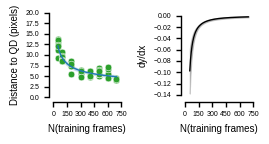

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(2.7, 1.45), sharex=True, sharey=False)
sns.lineplot(
    data=fit_df,
    x="x",
    y="y",
    legend=False,
    errorbar=("pi",95),
    hue="model_weight",
    # color="k",
    ax=ax[0],
)
sns.scatterplot(
    data=plt_df2,
    x="nframes train",
    y="value",
    legend=False,
    color=palette["reflect+fluo"],
    ax=ax[0],
    # hue="variable",
    # hue_order=["kpoint_com_gauss_gt_l2"],
)

sns.lineplot(
    data=fit_df,
    x="x",
    y="y_diff",
    legend=False,
    errorbar=("pi",95),
    color="k",
    ax=ax[1],
)
ax[1].set_ylabel("dy/dx")
ax[1].set_xlabel("N(training frames)")
# ax.plot(np.arange(50, 700), power_law_decay(np.arange(50,700), *popt))
ax[0].set_xticks(np.arange(0,801,150))
ax[0].set_xlabel("N(training frames)")
ax[0].set_ylabel("Distance to QD (pixels)")
ax[0].set_ylim(0,20)
sns.despine(offset=3,trim=True)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# ax.set_yscale("log")
fig.tight_layout()
# fig.savefig(os.path.join(fig_dir, "manual_label_performance_subsample.pdf"), bbox_inches="tight", dpi=600)

In [42]:
# get the derivative across all fits???

# Parameter scan

In [43]:
param_df = result_df.query("filename.str.contains('sweep') and dset_type == @dset_type").copy()

In [44]:
chk_params = [
    "backbone_output_stride",
    "backbone_filters",
    "backbone_filters_rate",
    "backbone_max_stride",
    "head_output_stride",
    "head_sigma",
]
output_var = ["kpoint_gt_l2"]

In [45]:
param_df = (
    param_df
    # param_df.query("backbone_filters_rate == 2 and backbone_filters == 64")
    .groupby(chk_params + ["model_dir"])[output_var]
    .mean()
    .reset_index()
)

In [46]:
cmap_kwargs = {
    "cmap": "spring",
    "vmin": 3,
    "vmax": 6,
    "linewidths": .5,
    "linecolor": "black",
}

/tmp/ipykernel_243880/1942824643.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


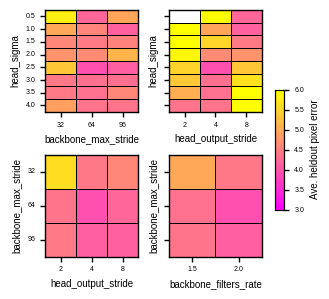

In [47]:
fig, ax = plt.subplots(2, 2, figsize=(3., 3.), sharey="row", sharex=False)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
sns.heatmap(
    param_df.groupby(["head_sigma", "backbone_max_stride"])["kpoint_gt_l2"]
    .min()
    .unstack(),
    ax=ax[0][0],
    cbar=False,
    **cmap_kwargs,
)
sns.heatmap(
    param_df.groupby(["head_sigma", "head_output_stride"])["kpoint_gt_l2"]
    .min()
    .unstack(),
    ax=ax[0][1],
    cbar=True,
    cbar_ax=cbar_ax,
    **cmap_kwargs,
)
sns.heatmap(
    param_df.groupby(["backbone_max_stride", "head_output_stride"])["kpoint_gt_l2"]
    .min()
    .unstack(),
    ax=ax[1][0],
    cbar=True,
    cbar_ax=cbar_ax,
    **cmap_kwargs,
)
h = sns.heatmap(
    param_df.groupby(["backbone_max_stride", "backbone_filters_rate"])["kpoint_gt_l2"]
    .min()
    .unstack(),
    ax=ax[1][1],
    cbar=True,
    cbar_ax=cbar_ax,
    **cmap_kwargs,
)
colorbar = h.collections[0].colorbar
colorbar.set_label("Ave. heldout pixel error")
# Set the spines of the colorbar axis
for _ax in ax.ravel():
    # _ax.set_yticklabels(_ax.get_yticklabels(), rotation=90)
    for _, spine in _ax.spines.items():
        spine.set_visible(True)
for spine in cbar_ax.spines.values():
    spine.set(visible=True, lw=0.8, edgecolor='black')
fig.tight_layout(rect=[0, 0, .9, 1])

ax[0][0].set_yticklabels(ax[0][0].get_yticklabels(), rotation=0)
ax[1][0].set_yticklabels(ax[1][0].get_yticklabels(), rotation=0)

fig.savefig(os.path.join(fig_dir, "manual_label_performance_parameter_sweeps.pdf"), bbox_inches="tight", dpi=600)